In [1]:
using Revise, LazySets, ReachabilityAnalysis, TaylorModels, IntervalArithmetic, Plots
const RA = ReachabilityAnalysis
const TM = TaylorModels
const IA = IntervalArithmetic

IntervalArithmetic

In [2]:
using ReachabilityAnalysis: symBox, zeroBox, post

In [10]:
# overapproximate taylor model reachset with several zonotopes
function _overapproximate(R::TaylorModelReachSet{N}, ::Type{<:Zonotope}, nparts::Int) where {N}
    # dimension of the reachset
    D = dim(R)

    # normalized time domain
    tdom = domain(R)

    # evaluate the Taylor model in time
    # X_Δt is a vector of TaylorN (spatial variables) whose coefficients are intervals
    X = set(R)
    X_Δt = TM.evaluate(X, tdom)
    
    # evaluate the spatial variables in the symmetric box
    partition = IA.mince(symBox(D), nparts)
    fX̂ = Vector{Vector{TaylorModelN{length(X_Δt), N, N}}}(undef, length(partition))
    @inbounds for (i, Bi) in enumerate(partition)
        x0 = IA.IntervalBox(IA.Interval.(RA.center(convert(Hyperrectangle, Bi))))
        X̂ib = [TaylorModelN(X_Δt[j], X[j].rem, x0, Bi) for j in 1:D]
        fX̂[i] = TaylorModels.fp_rpa.(X̂ib)
    end
    #return @which overapproximate(fX̂[1], Zonotope)
    #Z = overapproximate.(fX̂, Zonotope)
    Z = Vector{Zonotope}(undef, length(partition))
    for (i, X) in enumerate(fX̂)
        Z[i] = overapproximate(X, Zonotope)
    end
    
    Δt = tspan(R)
    #return ReachSet(UnionSetArray(Z), Δt) # but UnionSetArray is not yet a lazyset
    #return ReachSet(ConvexHullArray(Z), Δt)
    return Z
end

_overapproximate (generic function with 1 method)

In [11]:
@taylorize function f_quad!(dy, y, p, t) 
    dy[1] = 1 - y[1]^2
    dy[2] = 2*y[1]*y[2]
end

In [12]:
n = 2
orderQ = 2
orderT = 8
x = set_variables("x", numvars=n, order=orderQ)

xtm1 = TaylorModel1(Taylor1(x[1], orderT), RA.zeroI, RA.zeroI, RA.zeroI)
xtm2 = TaylorModel1(Taylor1(x[1]^2, orderT), RA.zeroI, RA.zeroI, RA.zeroI)

X0tm = TaylorModelReachSet([xtm1, xtm2], RA.zeroI)

alg = TMJets(orderT=8, orderQ=2, abs_tol=1e-13)
ivp = @ivp(x' = f_quad!(x), x(0) ∈ X0tm, dim=2)
sol = post(alg, ivp, 0 .. 1.0);

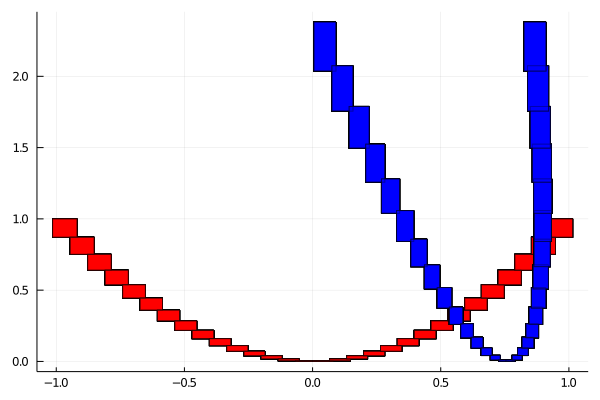

In [13]:
plot(UnionSetArray(overapproximate(sol[1], Hyperrectangle, 30).X.array), c=:red)

plot!(UnionSetArray(overapproximate(sol[end], Hyperrectangle, 30).X.array), c=:blue)

In [14]:
plot(UnionSetArray(_overapproximate(sol[1], Zonotope, 2).X.array), c=:red)

plot!(UnionSetArray(_overapproximate(sol[end], Zonotope, 2).X.array), c=:blue)

LoadError: [91mtype Array has no field X[39m

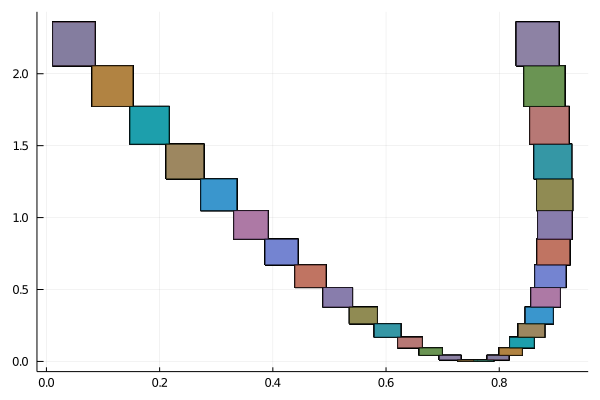

In [17]:
fig = plot()
[plot!(fig, i) for i in _overapproximate(sol[end], Zonotope, 30)]
fig

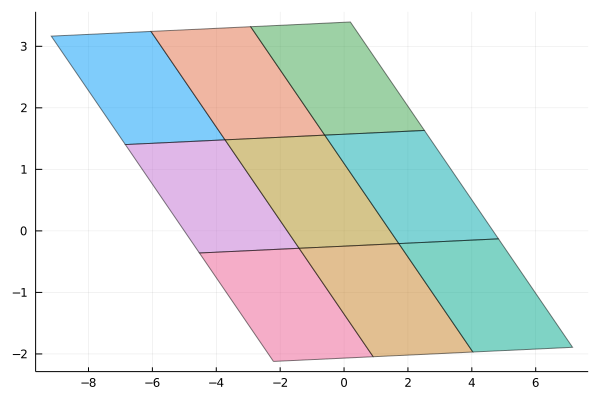

In [26]:
Z = rand(Zonotope)
T = overapproximate(Z, TaylorModelReachSet)
Tz = _overapproximate(T, Zonotope, 3)
fig = plot()
[plot!(fig, i) for i in Tz]
fig